In [1]:
# Put reload
%reload_ext autoreload
%autoreload 2

# Imports

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from sklearn.metrics import roc_auc_score
from torchvision import datasets
from tqdm import tqdm

sys.path.append("..")

from ratefunctiontorch import RateCumulant

In [3]:
BATCH_SIZE = 50


# Load Resnet And Datasets

In [4]:
model = torch.hub.load(
    "chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True
)

Using cache found in C:\Users\Ludvins/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [5]:
# Load CIFAR10 data
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

testset_svhn = datasets.SVHN(
    root="./data", split="test", download=True, transform=transform
)
test_loader2 = torch.utils.data.DataLoader(
    testset_svhn,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data\test_32x32.mat


In [6]:
ratecumulant = RateCumulant(model, test_loader)

# Cummulant

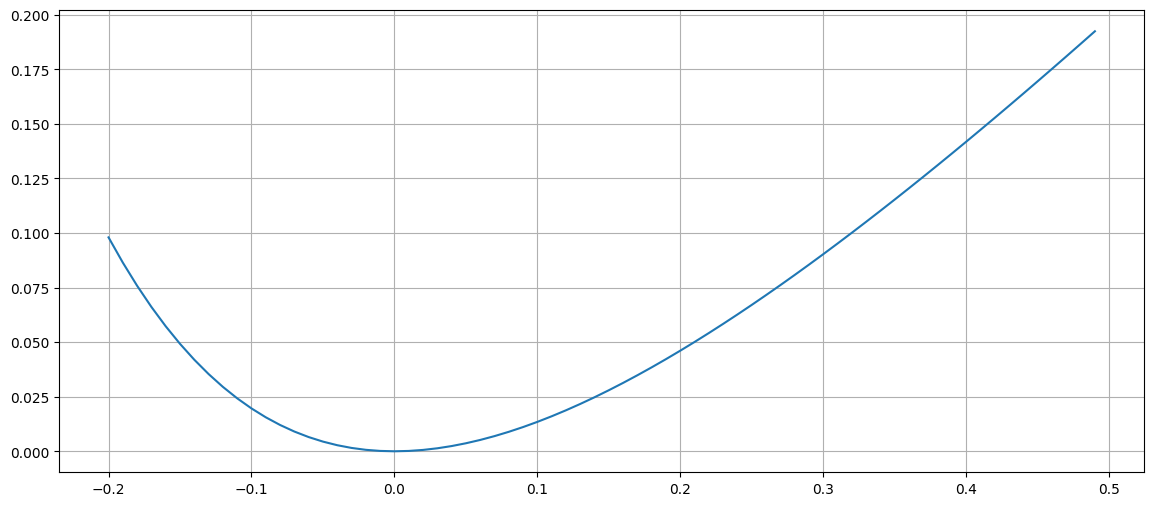

In [7]:
lambdas = np.arange(-0.2, 0.5, 0.01)
cummulant = ratecumulant.compute_cumulants(lambdas)

plt.rcParams["figure.figsize"] = (14, 6)
plt.plot(lambdas, cummulant)
plt.grid()
plt.show()

# Rate Function

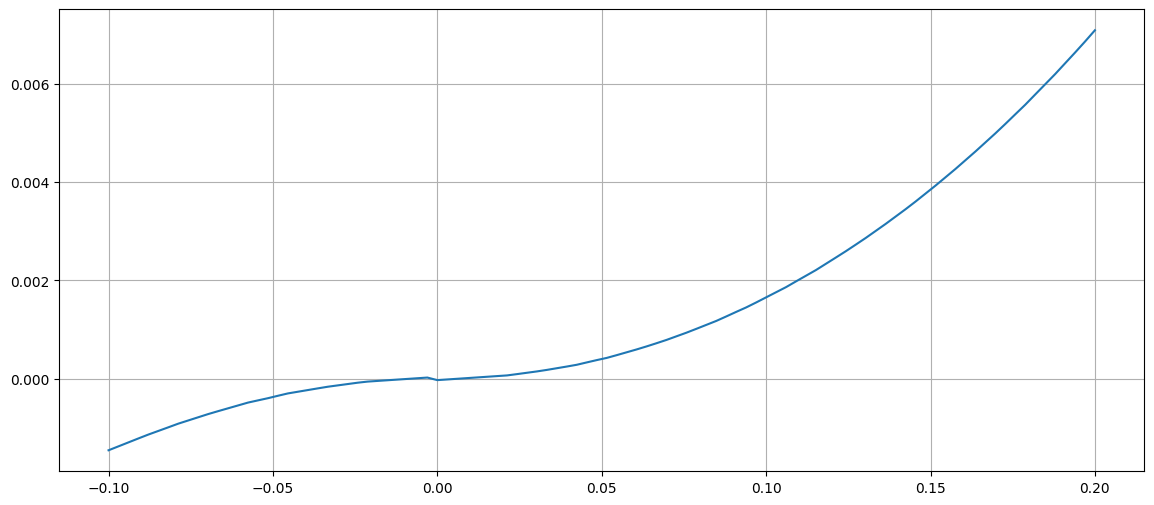

In [8]:
s_values = np.linspace(-0.1, 0.2, 100)


I = ratecumulant.compute_rate_function(s_values)

plt.rcParams["figure.figsize"] = (14, 6)
plt.plot(s_values, I)
plt.grid()
plt.show()

# OOD

## Precompute loss for 1000 elements of each dataset

In [9]:
test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=1,
    shuffle=True,
)

test_loader2 = torch.utils.data.DataLoader(
    testset_svhn,
    batch_size=1,
    shuffle=True,
)

In [10]:
# Compute the loss on batches of the test set
losses_cifar = []
losses_svhn = []
n_batches = 1000
test_iter = iter(test_loader)
test_iter_svhn = iter(test_loader2)
for i in tqdm(range(n_batches)):
    try:
        inputs, labels = next(test_iter)
    except StopIteration:
        test_iter = iter(test_loader)

    outputs = model(inputs)
    loss = torch.nn.functional.cross_entropy(outputs, labels)
    losses_cifar.append(loss.item())

    try:
        inputs, labels = next(test_iter_svhn)
    except StopIteration:
        test_iter_svhn = iter(test_loader2)

    outputs = model(inputs)
    loss = torch.nn.functional.cross_entropy(outputs, labels)
    losses_svhn.append(loss.item())


100%|██████████| 1000/1000 [00:05<00:00, 185.27it/s]


## Compute and plot generalization errors. SVHN uses Cifar10 population loss

In [11]:
gen_errors_cifar = np.array(losses_cifar) - np.mean(losses_cifar)
gen_errors_svhn = np.array(losses_svhn) - np.mean(losses_cifar)

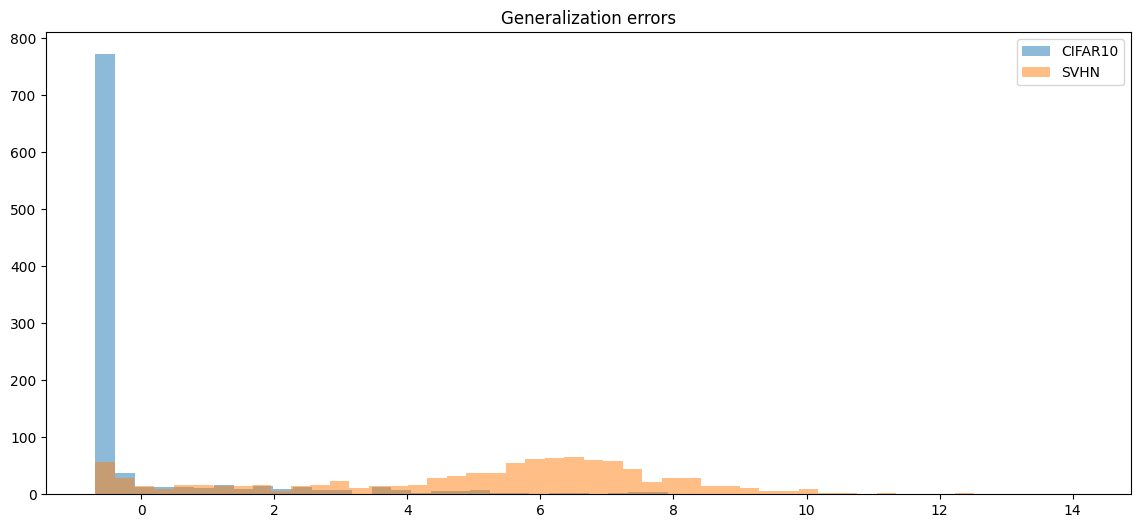

In [12]:
plt.hist(gen_errors_cifar, bins=50, alpha=0.5, label="CIFAR10")
plt.hist(gen_errors_svhn, bins=50, alpha=0.5, label="SVHN")
plt.legend()
plt.title("Generalization errors")
plt.show()

## Compute entropies and the AUC

In [13]:
# Compute the loss on batches of the test set
H_cifar = []
H_svhn = []
n_batches = 1000
test_iter = iter(test_loader)
test_iter_svhn = iter(test_loader2)
for i in tqdm(range(n_batches)):
    try:
        inputs, labels = next(test_iter)
    except StopIteration:
        test_iter = iter(test_loader)

    outputs = model(inputs).softmax(dim=1)

    # Compute entropy of predictions
    H = -torch.sum(outputs * torch.log(outputs), dim=1).detach().cpu().numpy()
    H_cifar.append(H)

    try:
        inputs, labels = next(test_iter_svhn)
    except StopIteration:
        test_iter_svhn = iter(test_loader2)

    outputs = model(inputs).softmax(dim=1)
    H = -torch.sum(outputs * torch.log(outputs), dim=1).detach().cpu().numpy()
    H_svhn.append(H)

100%|██████████| 1000/1000 [00:05<00:00, 181.35it/s]


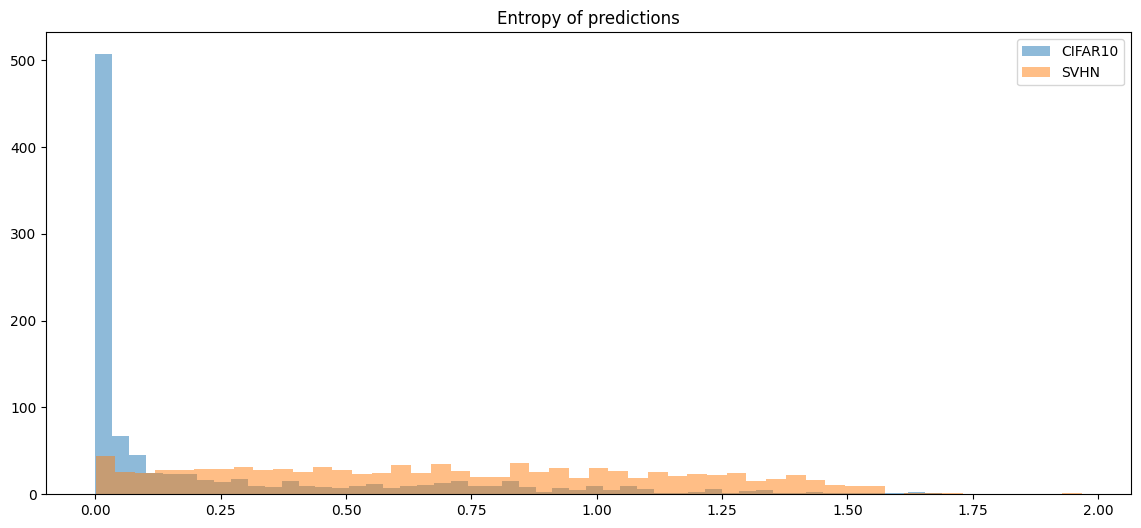

In [14]:
plt.hist(np.concatenate(H_cifar), bins=50, alpha=0.5, label="CIFAR10")
plt.hist(np.concatenate(H_svhn), bins=50, alpha=0.5, label="SVHN")
plt.legend()
plt.title("Entropy of predictions")
plt.show()

In [15]:
# Compute ouc on gen_errors_cifar and gen_errors_svhn
auc = roc_auc_score(
    [0] * len(H_cifar) + [1] * len(H_svhn),
    np.concatenate([H_cifar, H_svhn]),
)

print(f"AUC: {auc}")

AUC: 0.823472


## Compute Alphas and the AUC

In [16]:
alphas_cifar = ratecumulant.compute_rate_function(gen_errors_cifar)
alphas_svhn = ratecumulant.compute_rate_function(gen_errors_svhn)

In [17]:
# Compute ouc on gen_errors_cifar and gen_errors_svhn
auc = roc_auc_score(
    [0] * len(alphas_cifar) + [1] * len(alphas_svhn),
    np.concatenate([alphas_cifar, alphas_svhn]),
)

print(f"AUC: {auc}")

AUC: 0.943584


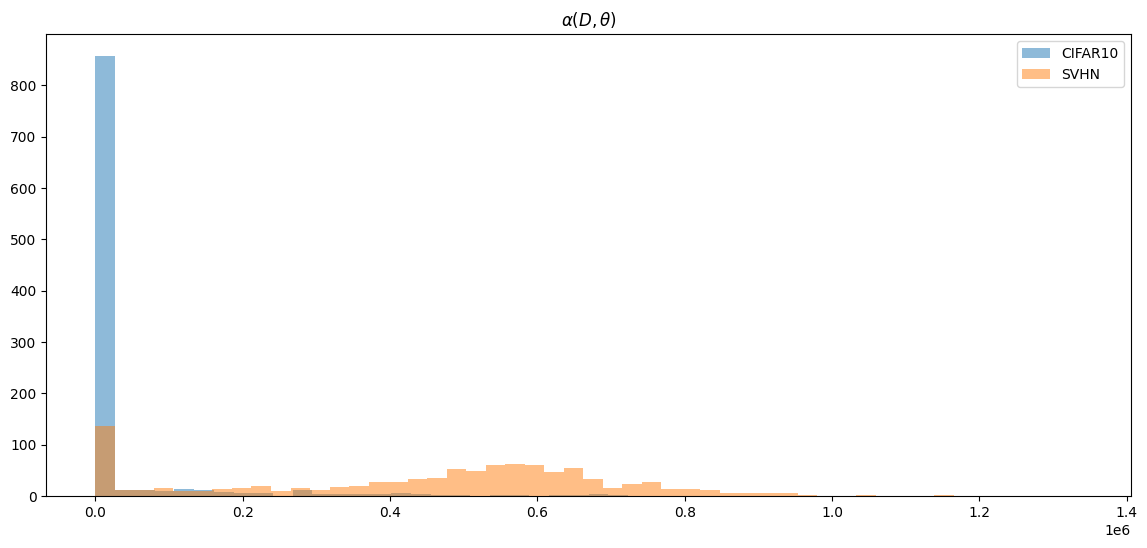

In [18]:
plt.hist(alphas_cifar, bins=50, alpha=0.5, label="CIFAR10")
plt.hist(alphas_svhn, bins=50, alpha=0.5, label="SVHN")
plt.title(r"$\alpha(D, \theta)$")
plt.legend()
plt.show()

## Compute probabilities using exponential CDF

In [19]:
# Take iteratively batches from cifar10 and svhn
n_batches = 10
test_iter = iter(test_loader)
test_iter_svhn = iter(test_loader2)

for i in range(n_batches):
    try:
        inputs, labels = next(test_iter)
    except StopIteration:
        test_iter = iter(test_loader)

    outputs = model(inputs)
    loss = torch.nn.functional.cross_entropy(outputs, labels)

    alpha = ratecumulant.compute_rate_function(loss.item())

    print(
        "\nCifar10 sample with loss {} and alpha {}.".format(loss.item(), alpha.item())
    )
    print(
        "Probability of being out of distribution: ", 1 - np.exp(-np.abs(alpha.item()))
    )

    try:
        inputs, labels = next(test_iter_svhn)
    except StopIteration:
        test_iter_svhn = iter(test_loader2)

    outputs = model(inputs)
    loss = torch.nn.functional.cross_entropy(outputs, labels)

    alpha = ratecumulant.compute_rate_function(loss.item())
    print("\nSVHN sample with loss {} and alpha {}.".format(loss.item(), alpha.item()))
    print(
        "Probability of being out of distribution: ", 1 - np.exp(-np.abs(alpha.item()))
    )



Cifar10 sample with loss 0.10501353442668915 and alpha 0.0018259072676301003.
Probability of being out of distribution:  0.0018242413130689084

SVHN sample with loss 7.632206439971924 and alpha 688597.75.
Probability of being out of distribution:  1.0

Cifar10 sample with loss 0.007827797904610634 and alpha 2.614087861729786e-06.
Probability of being out of distribution:  2.6140844450184275e-06

SVHN sample with loss 7.357265472412109 and alpha 661103.6875.
Probability of being out of distribution:  1.0

Cifar10 sample with loss 6.365573790390044e-05 and alpha -3.249447763664648e-05.
Probability of being out of distribution:  3.2493949696843494e-05

SVHN sample with loss 6.49022102355957 and alpha 574399.25.
Probability of being out of distribution:  1.0

Cifar10 sample with loss 0.03350340947508812 and alpha 0.00017758263857103884.
Probability of being out of distribution:  0.00017756687170755736

SVHN sample with loss 5.413815498352051 and alpha 466758.6875.
Probability of being out

In [20]:
def evaluate_ood(n_batches, threshold):
    # Initialize counters for CIFAR-10 (ID) and SVHN (OOD)
    ID_TP, ID_FP, ID_TN, ID_FN = 0, 0, 0, 0  # For CIFAR-10 (In-Distribution)
    OOD_TP, OOD_FP, OOD_TN, OOD_FN = 0, 0, 0, 0  # For SVHN (Out-of-Distribution)

    # Function to compute the probability of being OOD
    def compute_ood_probability(alpha):
        return 1 - np.exp(-np.abs(alpha))

    # CIFAR-10 (In-Distribution) Evaluation (Subset)
    test_iter = iter(test_loader)
    for _ in tqdm(range(n_batches), desc="CIFAR-10 Evaluation (ID)"):
        try:
            inputs, labels = next(test_iter)
        except StopIteration:
            break  # In case we run out of data before reaching n_batches

        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels, reduction="none")

        for loss_value in loss:
            alpha = ratecumulant.compute_rate_function(loss_value.item())
            probability_ood = compute_ood_probability(alpha.item())

            # Classify as OOD or not
            is_ood = probability_ood > threshold

            if is_ood:  # False positive (incorrectly classified as OOD)
                ID_FP += 1
            else:  # True negative (correctly classified as in-distribution)
                ID_TN += 1

    # SVHN (Out-of-Distribution) Evaluation (Subset)
    test_iter_svhn = iter(test_loader2)
    for _ in tqdm(range(n_batches), desc="SVHN Evaluation (OOD)"):
        try:
            inputs, labels = next(test_iter_svhn)
        except StopIteration:
            break  # In case we run out of data before reaching n_batches

        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels, reduction="none")

        for loss_value in loss:
            alpha = ratecumulant.compute_rate_function(loss_value.item())
            probability_ood = compute_ood_probability(alpha.item())

            # Classify as OOD or not
            is_ood = probability_ood > threshold

            if is_ood:  # True positive (correctly classified as OOD)
                OOD_TP += 1
            else:  # False negative (missed OOD)
                OOD_FN += 1

    ID_accuracy = (ID_TN) / (ID_TN + ID_FP) if (ID_TN + ID_FP) > 0 else 0
    OOD_accuracy = (OOD_TP) / (OOD_TP + OOD_FN) if (OOD_TP + OOD_FN) > 0 else 0

    # Return the results
    return {
        "ID_accuracy": ID_accuracy,
        "OOD_accuracy": OOD_accuracy,
        "ID_TN": ID_TN,
        "ID_FP": ID_FP,
        "OOD_TP": OOD_TP,
        "OOD_FN": OOD_FN,
    }


# Now call the function for different thresholds
thresholds = [0.90, 0.95, 0.99]

for threshold in thresholds:
    print(f"\nEvaluating with threshold {threshold}:")
    results = evaluate_ood(n_batches=1000, threshold=threshold)

    print(f"\nResults for threshold {threshold}:")
    print(f"CIFAR-10 (ID) Accuracy: {results['ID_accuracy'] * 100:.2f}%")
    print(f"SVHN (OOD) Accuracy: {results['OOD_accuracy'] * 100:.2f}%")
    print(
        f"ID True Negatives: {results['ID_TN']}, ID False Positives: {results['ID_FP']}"
    )
    print(
        f"OOD True Positives: {results['OOD_TP']}, OOD False Negatives: {results['OOD_FN']}"
    )



Evaluating with threshold 0.9:


SVHN Evaluation (OOD): 100%|██████████| 1000/1000 [00:22<00:00, 44.26it/s]



Results for threshold 0.9:
CIFAR-10 (ID) Accuracy: 78.40%
SVHN (OOD) Accuracy: 91.20%
ID True Negatives: 784, ID False Positives: 216
OOD True Positives: 912, OOD False Negatives: 88

Evaluating with threshold 0.95:


SVHN Evaluation (OOD): 100%|██████████| 1000/1000 [00:22<00:00, 44.36it/s]



Results for threshold 0.95:
CIFAR-10 (ID) Accuracy: 81.00%
SVHN (OOD) Accuracy: 89.30%
ID True Negatives: 810, ID False Positives: 190
OOD True Positives: 893, OOD False Negatives: 107

Evaluating with threshold 0.99:


SVHN Evaluation (OOD): 100%|██████████| 1000/1000 [00:22<00:00, 44.13it/s]


Results for threshold 0.99:
CIFAR-10 (ID) Accuracy: 78.30%
SVHN (OOD) Accuracy: 91.70%
ID True Negatives: 783, ID False Positives: 217
OOD True Positives: 917, OOD False Negatives: 83
